### 1. Read data into dataframes

In [137]:
import pandas as pd

data = pd.read_csv('data/data_title_fully_processed.csv')
titles = data['processed_title']
data = pd.read_csv('data/date_popularity_processed.csv')
popularity = data['popularity']

### 2. Process text

In [138]:
from text_processing import process_text

title_tokens = []
for title in titles:
    title_tokens.append((str(title)).split(' '))

title_tokens[:10]

[['meet', 'founder', 'blog', 'revolution'],
 ['averting', 'climate', 'crisis'],
 ['simplicity', 'sell'],
 ['chemical', 'scum', 'dream', 'distant', 'quasar'],
 ['wish', 'global', 'day', 'film'],
 ['love', 'cheat'],
 ['happiness', 'body', 'soul'],
 ['life', 'purpose'],
 ['rebuild', 'broken', 'state'],
 ['school', 'kill', 'creativity']]

### 3. Run apriori association rule mining

In [139]:
from apyori import apriori
results = list(apriori(title_tokens, min_support = 0.001, min_confidence = 0.1))
print(len(results))
results[:10]

81


[RelationRecord(items=frozenset({'3', 'way'}), support=0.005150062155922571, ordered_statistics=[OrderedStatistic(items_base=frozenset({'3'}), items_add=frozenset({'way'}), confidence=0.3918918918918919, lift=17.79631647776809), OrderedStatistic(items_base=frozenset({'way'}), items_add=frozenset({'3'}), confidence=0.2338709677419355, lift=17.79631647776809)]),
 RelationRecord(items=frozenset({'4', 'way'}), support=0.0014207068016338128, ordered_statistics=[OrderedStatistic(items_base=frozenset({'4'}), items_add=frozenset({'way'}), confidence=0.2424242424242424, lift=11.008797653958943)]),
 RelationRecord(items=frozenset({'5', 'way'}), support=0.0010655301012253596, ordered_statistics=[OrderedStatistic(items_base=frozenset({'5'}), items_add=frozenset({'way'}), confidence=0.23076923076923078, lift=10.47952853598015)]),
 RelationRecord(items=frozenset({'action', 'climate'}), support=0.0031965903036760787, ordered_statistics=[OrderedStatistic(items_base=frozenset({'action'}), items_add=fro

### 4. Tune hyperparameters

##### With confidence threshold of 0, no rules are found past a support threshold of 0.04.

In [140]:
results = list(apriori(title_tokens, min_support = 0.04, min_confidence = 0.0))
len(results)

0

##### Examine behavior of rule count wrt. support thresholds between (0, 0.04) at two different confidence thresholds.

In [141]:
import numpy as np
import matplotlib.pyplot as plot

support = np.arange(0.001, 0.04, 0.001)
rules0 = np.empty_like(support)
rules1 = np.empty_like(support)
for i, sup in enumerate(support):
    rules0[i] = len(list(apriori(title_tokens, min_support = sup, min_confidence = 0.0)))
    rules1[i] = len(list(apriori(title_tokens, min_support = sup, min_confidence = 0.1)))

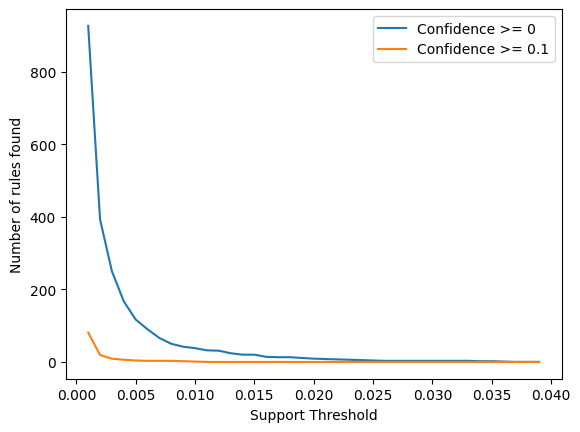

In [142]:
plot.plot(support, rules0, label='Confidence >= 0')
plot.plot(support, rules1, label='Confidence >= 0.1')
plot.xlabel('Support Threshold')
plot.ylabel('Number of rules found')
plot.legend()

##### By visual inspection, support threshold elbow appears to occur between 0.0025 and 0.0075.
##### Examine behavior of rule count wrt. confidence thresholds at support thresholds between 0.0025 and 0.0075.

In [143]:
conf = np.arange(0.0, 0.2, 0.001)
rules25 = np.empty_like(conf)
rules50 = np.empty_like(conf)
rules75 = np.empty_like(conf)
for i, cf in enumerate(conf):
    rules25[i] = len(list(apriori(title_tokens, min_support = 0.0025, min_confidence = cf)))
    rules50[i] = len(list(apriori(title_tokens, min_support = 0.005, min_confidence = cf)))
    rules75[i] = len(list(apriori(title_tokens, min_support = 0.0075, min_confidence = cf)))

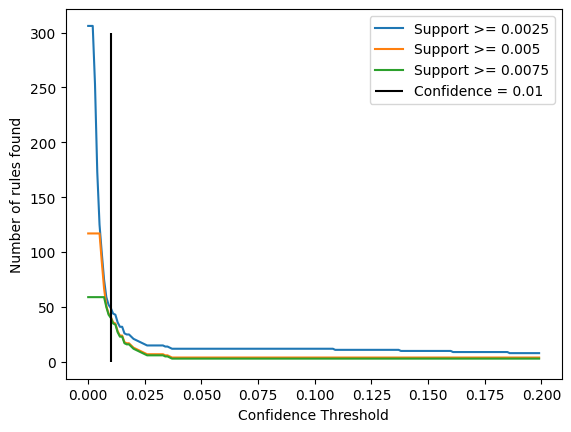

In [144]:
cthresh = 0.01

plot.plot(conf, rules25, label='Support >= 0.0025')
plot.plot(conf, rules50, label='Support >= 0.005')
plot.plot(conf, rules75, label='Support >= 0.0075')
plot.vlines(cthresh, 0, 300, colors='black', label=f'Confidence = {cthresh}')

plot.xlabel('Confidence Threshold')
plot.ylabel('Number of rules found')
plot.legend()

##### At this interval of support thresholds, defining the confidence threshold at 0.01 prevents rule count from blowing up.
##### Examine behavior of rule count wrt. support thresholds at confidence threshold of 0.01

In [145]:
rules01 = np.empty_like(support)
for i, sup in enumerate(support):
    rules01[i] = len(list(apriori(title_tokens, min_support = sup, min_confidence = cthresh)))

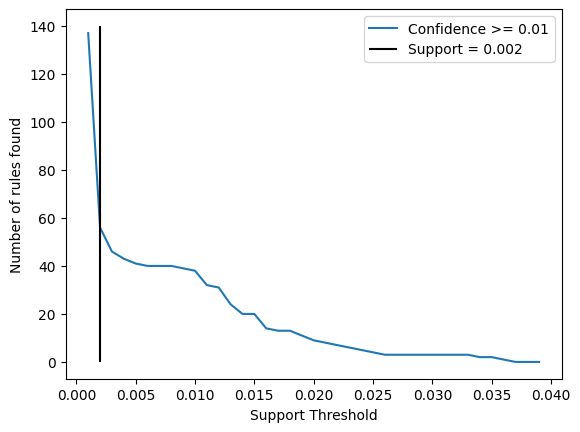

In [146]:
sthresh = 0.002
plot.plot(support, rules01, label='Confidence >= 0.01')
plot.vlines(sthresh, 0, 140, colors='black', label=f'Support = {sthresh}')

plot.xlabel('Support Threshold')
plot.ylabel('Number of rules found')
plot.legend()

##### At a confidence threshold of 0.01, defining the support threshold at 0.002 prevents rule count from blowing up.

### 5. Run apriori association rule mining with tuned hyperparameters

In [147]:
results = list(apriori(title_tokens, min_support = sthresh, min_confidence = cthresh))
title_rules = []
for rule in results:
    title_rules.append([rule.items, rule.support, rule.ordered_statistics[0].confidence])
df = pd.DataFrame(title_rules, columns=['Set', 'Support', 'Confidence'])

##### Sort sets by highest support

In [148]:
df.sort_values(by=['Support'], ascending=False)

,Set,Support,Confidence
17,(life),0.036583,0.036583
36,(world),0.035518,0.035518
32,(u),0.033742,0.033742
9,(future),0.025573,0.025573
20,(make),0.024507,0.024507
22,(new),0.023797,0.023797
33,(way),0.022021,0.022021
4,(change),0.021311,0.021311
21,(need),0.020067,0.020067
7,(could),0.019890,0.019890


##### Sort sets by highest confidence

In [149]:
df.sort_values(by=['Confidence'], ascending=False)

,Set,Support,Confidence
39,"(brief, history)",0.002131,0.923077
53,"(riddle, solve)",0.009767,0.901639
38,"(action, climate)",0.003197,0.666667
40,"(care, health)",0.003197,0.580645
55,"(teach, u)",0.004085,0.460000
41,"(climate, change)",0.008879,0.416667
37,"(3, way)",0.005150,0.391892
44,"(life, day)",0.002309,0.351351
45,"(health, mental)",0.002486,0.237288
48,"(look, like)",0.002664,0.197368
